### Add an equation for the vapor mixing ratio

In [21]:
def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

#
# helper function to turn a dictionary into a named tuple
#
from collections import namedtuple
def make_tuple(tupname,in_dict):
    the_tup = namedtuple(tupname, in_dict.keys())
    the_tup = the_tup(**in_dict)
    return the_tup


In [22]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd
import thermlib
from importlib import reload
reload(thermlib)
from thermlib import thermfuncs as tf



def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    eta = 0.8
    delF = 0.035
    went = eta*delF/deltheta  #entrainment velocity (positive upward)
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - coeffs.radcool/1004./the_vars[1]
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

In [23]:
reload(thermlib)
from thermlib import thermfuncs as tf
dtout=10.  #minutes
end_time=8*24.   #hours
del_time=dtout*60. #seconds
end_time=end_time*3600. #seconds
sst=295
D=5.e-6  #s-1
U=10  #m/s
psfc=100. #kPa
qsfc=tf.qs_tp(sst,psfc)
ft_intercept = 288 #K
ft_gamma = 6.e-3  #K/m
ft_qv = 2.e-3
k=0.2  #entrainment efficiency
Cd = 1.e-3  #drag coefficient
tspan = np.arange(0.,end_time,del_time)
vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
             qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd,radcool=30.)
the_tup=make_tuple('coeffs',the_tup)
output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])
result['time']=tspan/3600./24.  #days
result['deltheta'] = theta_ft(result['h'].values,ft_intercept,ft_gamma) - result['theta']

# Calc Went following paramterization of de Roode

### using the parameterizations listed on slide 9
    
## H reaches equilibrium ~ where the graph in slide 9 says it shoud

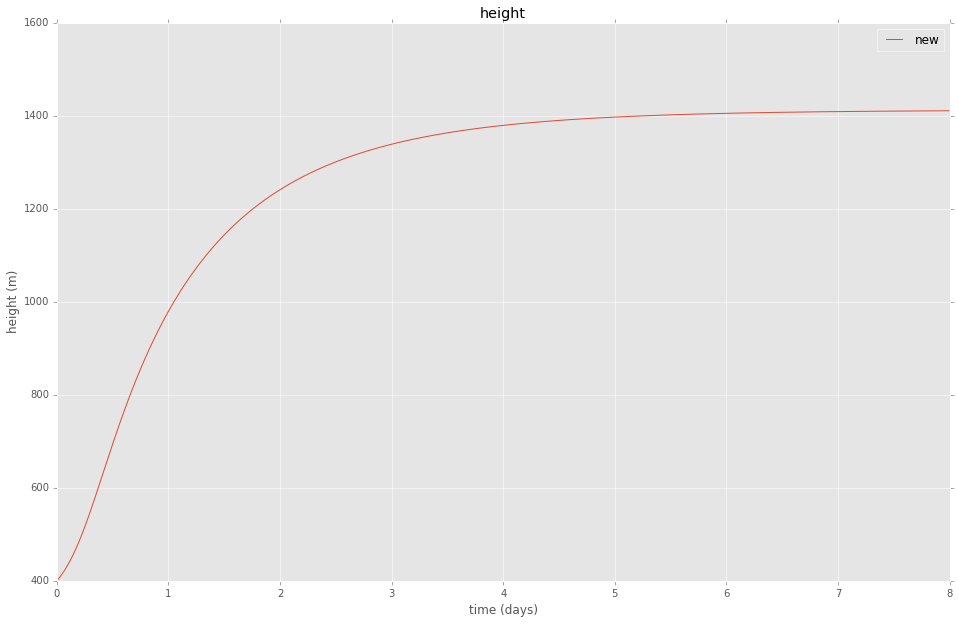

In [24]:
%matplotlib inline
plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.plot(result['time'],result['h'],label='new')
ax.set(ylabel='height (m)',xlabel='time (days)',title='height')
ax.legend(loc='best')
